In [2]:
library(dplyr)
library(stringr)
library(Seurat) # Seurat v4.1.0
library(Matrix)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(ggbeeswarm)
library(ggpubr)


In [3]:
folder_list = list.dirs(path = '../gex_output/', full.names = TRUE, recursive = FALSE)
folder_list

[1] "../gex_output//dna1_gex"     "../gex_output//dna2_gex"    
[3] "../gex_output//protein1_gex" "../gex_output//protein2_gex"

In [4]:
folder_list = list.dirs(path = '../hto_output/', full.names = FALSE, recursive = FALSE)
sample_list=folder_list[!startsWith(folder_list,'HTO')]
sample_list

[1] "dna1_hto"     "dna2_hto"     "protein1_hto" "protein2_hto"

In [8]:
hto.mtx = Read10X(paste0('../hto_output/','dna1','_hto'))
head(hto.mtx)

  [[ suppressing 34 column names ‘AAACCAAAGAAACGCG-1’, ‘AAACCAAAGAAATTGG-1’, ‘AAACCAAAGAACTCAT-1’ ... ]]



4 x 273926 sparse Matrix of class "dgCMatrix"
                                                                              
TotalSeq-C0301 . . 1 .  . . . 1 . . 1 . 1 3 1 . 2 . . . . 1 . . 2  1 . . . . 1
TotalSeq-C0302 . 1 . .  . 1 . . . . 1 . 1 . 3 1 . . . . 1 . 1 . .  1 . . . . .
TotalSeq-C0303 . . . 1 10 . 1 . 1 . 3 . 1 . . 1 . 1 5 . . . . 1 . 90 4 1 . 2 .
TotalSeq-C0304 . . . .  . . . . . . . . . . . . . . . . . . . . .  . . . 1 1 .
                           
TotalSeq-C0301 1 . . ......
TotalSeq-C0302 . . . ......
TotalSeq-C0303 1 1 1 ......
TotalSeq-C0304 . . 1 ......

 .....suppressing 273892 columns in show(); maybe adjust options(max.print=, width=)
 ..............................

In [9]:
sample_list = c('dna1','dna2','protein1','protein2')
srat_list=NULL
for (sample in sample_list) {
    print(sample)
    # read in file
    gex_path = paste0('../gex_output/',sample, '_gex')
    hto_path = paste0('../hto_output/',sample,'_hto')
    gex.mtx = Read10X(gex_path)
    hto.mtx = Read10X(hto_path)
    # create seurat object 
    seurat_obj = CreateSeuratObject(counts = gex.mtx, project=sample, min.cells = 3, min.features = 100)
    # filter hto.mtx to match the cell barcode in seurat_obj  
    common_barcodes <- intersect(colnames(hto.mtx), colnames(seurat_obj))
    hto.mtx <- hto.mtx[, common_barcodes]
    hto.mtx = hto.mtx[1:4,] # used 4 HTO antibodies
    # filter seurat_obj to match the cell barcodes in hto.mtx
    seurat_obj <- subset(seurat_obj, cells = common_barcodes)
    # add HTO to seurat object
    seurat_obj[['HTO']]=CreateAssayObject(counts = hto.mtx) 
    # normalize and demultiplex
    seurat_obj <- NormalizeData(seurat_obj, assay = "HTO", normalization.method = "CLR")
    seurat_obj <- HTODemux(seurat_obj, assay = "HTO", positive.quantile = 0.99)
    # create cell_id column 
    seurat_obj$barcode = rownames(seurat_obj@meta.data)
    seurat_obj$cell_id = paste(seurat_obj$orig.ident,  seurat_obj$barcode, sep='_')
    # Rename cells 
    seurat_obj = RenameCells(seurat_obj, new.names = paste(seurat_obj$orig.ident,  seurat_obj$barcode, sep='_'))
    if (is.null(srat_list)) {
        srat_list <- seurat_obj
    } else {
        srat_list <- c(srat_list, seurat_obj)
    }
}

[1] "dna1"


Normalizing across features

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Cutoff for TotalSeq-C0301 : 32 reads

Cutoff for TotalSeq-C0302 : 358 reads

Cutoff for TotalSeq-C0303 : 92 reads

Cutoff for TotalSeq-C0304 : 4 reads



[1] "dna2"


Normalizing across features

Cutoff for TotalSeq-C0301 : 81 reads

Cutoff for TotalSeq-C0302 : 80 reads

Cutoff for TotalSeq-C0303 : 13 reads

Cutoff for TotalSeq-C0304 : 124 reads



[1] "protein1"


Normalizing across features

Cutoff for TotalSeq-C0301 : 525 reads

Cutoff for TotalSeq-C0302 : 29 reads

Cutoff for TotalSeq-C0303 : 13 reads

Cutoff for TotalSeq-C0304 : 18 reads



[1] "protein2"


Normalizing across features

Cutoff for TotalSeq-C0301 : 752 reads

Cutoff for TotalSeq-C0302 : 3 reads

Cutoff for TotalSeq-C0303 : 11 reads

Cutoff for TotalSeq-C0304 : 95 reads



In [10]:
srat_merged = merge(srat_list[[1]],srat_list[2:length(srat_list)])
srat_merged

An object of class Seurat 
16497 features across 6352 samples within 2 assays 
Active assay: RNA (16493 features, 0 variable features)
 4 layers present: counts.dna1, counts.dna2, counts.protein1, counts.protein2
 1 other assay present: HTO

In [11]:
saveRDS(srat_merged,'seurat_objects/00_merged_seurat.RDS')

Warning message in HTOHeatmap(srat, assay = "HTO"):
“ncells (5000) is larger than the number of cells present in the provided object (3464). Plotting heatmap for all cells.”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”



 Doublet Negative  Singlet 
     624      606     2234 

       Doublet       Negative TotalSeq-C0303 TotalSeq-C0301 TotalSeq-C0304 
           624            606           1268            740            175 
TotalSeq-C0302 
            51 


Warning message in HTOHeatmap(srat, assay = "HTO"):
“ncells (5000) is larger than the number of cells present in the provided object (1362). Plotting heatmap for all cells.”


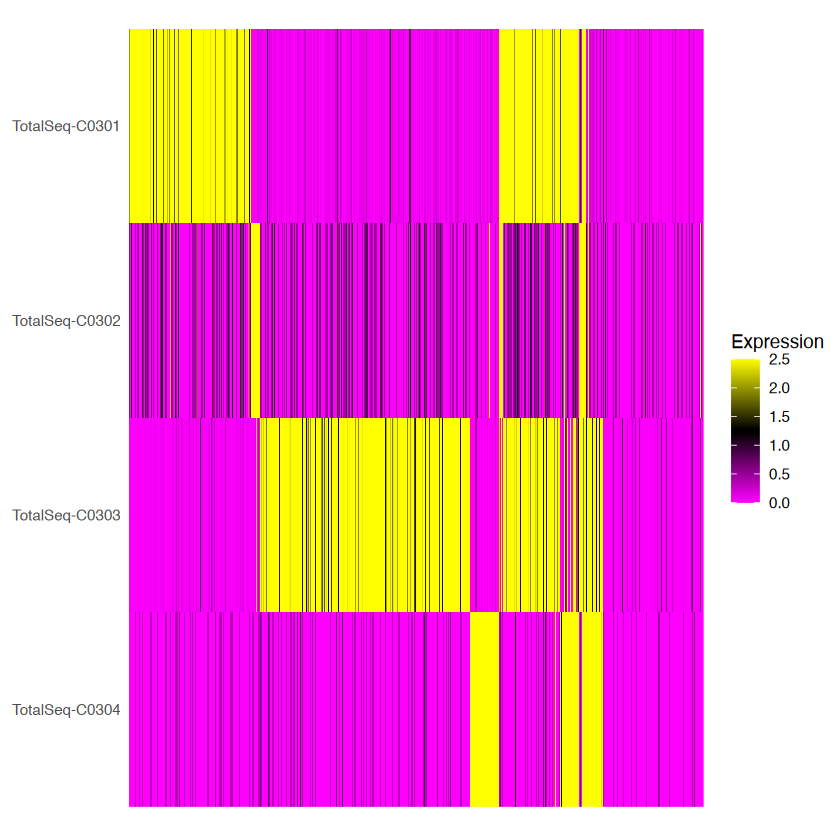


 Doublet Negative  Singlet 
     227      185      950 

       Doublet TotalSeq-C0304 TotalSeq-C0303 TotalSeq-C0301       Negative 
           227            353             78            380            185 
TotalSeq-C0302 
           139 


Warning message in HTOHeatmap(srat, assay = "HTO"):
“ncells (5000) is larger than the number of cells present in the provided object (534). Plotting heatmap for all cells.”


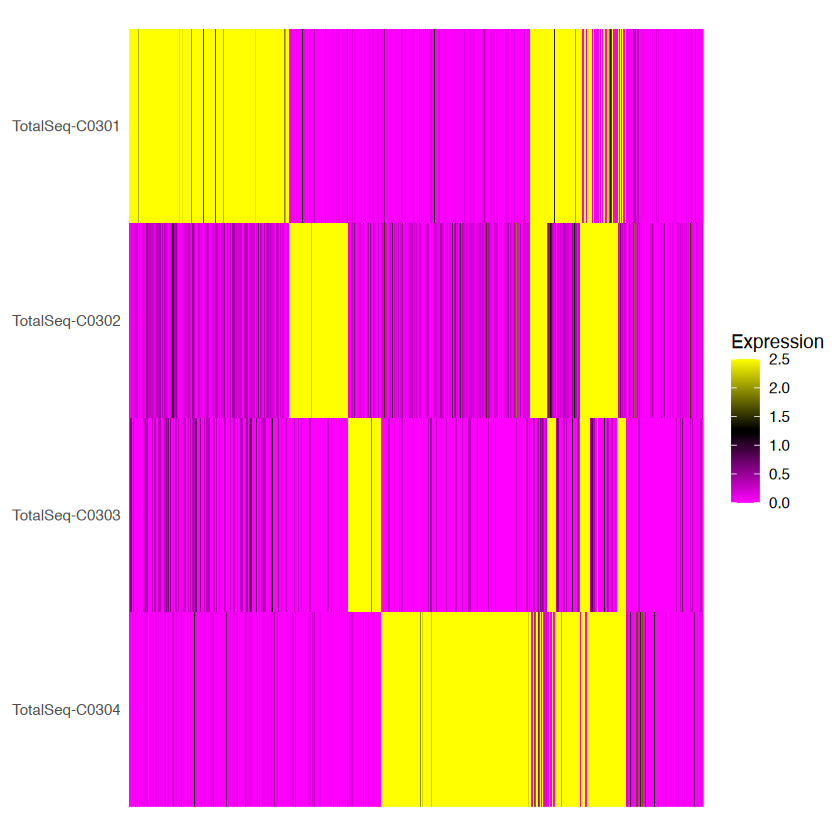


 Doublet Negative  Singlet 
      92       93      349 

       Doublet TotalSeq-C0301       Negative TotalSeq-C0302 TotalSeq-C0304 
            92            177             93             90             70 
TotalSeq-C0303 
            12 


Warning message in HTOHeatmap(srat, assay = "HTO"):
“ncells (5000) is larger than the number of cells present in the provided object (992). Plotting heatmap for all cells.”


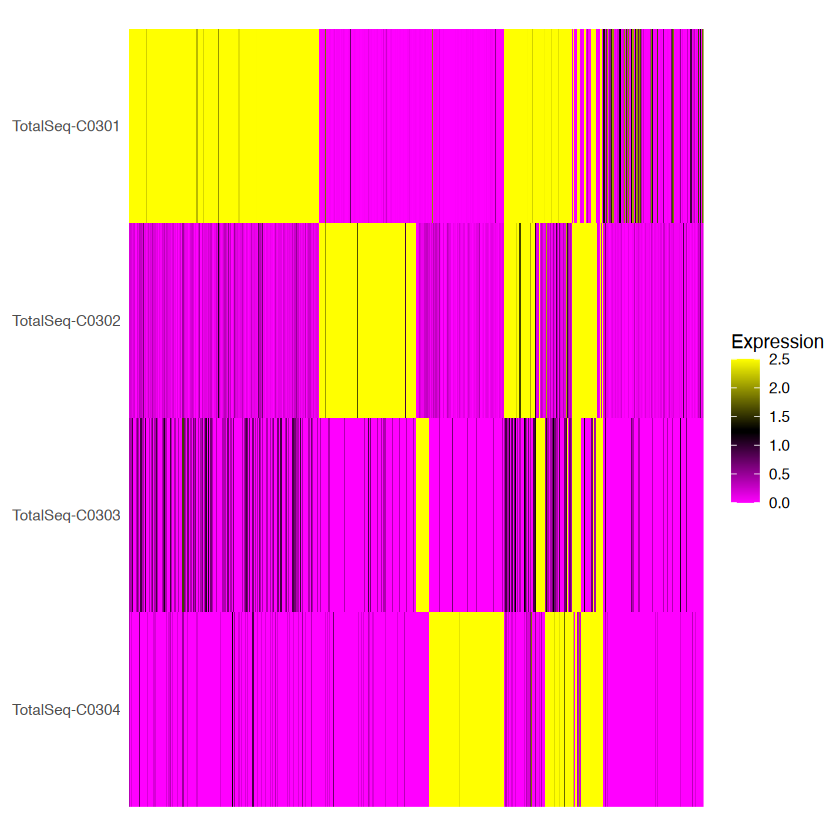


 Doublet Negative  Singlet 
     140      193      659 

       Doublet TotalSeq-C0301 TotalSeq-C0304       Negative TotalSeq-C0303 
           140            321            273            193             45 
TotalSeq-C0302 
            20 


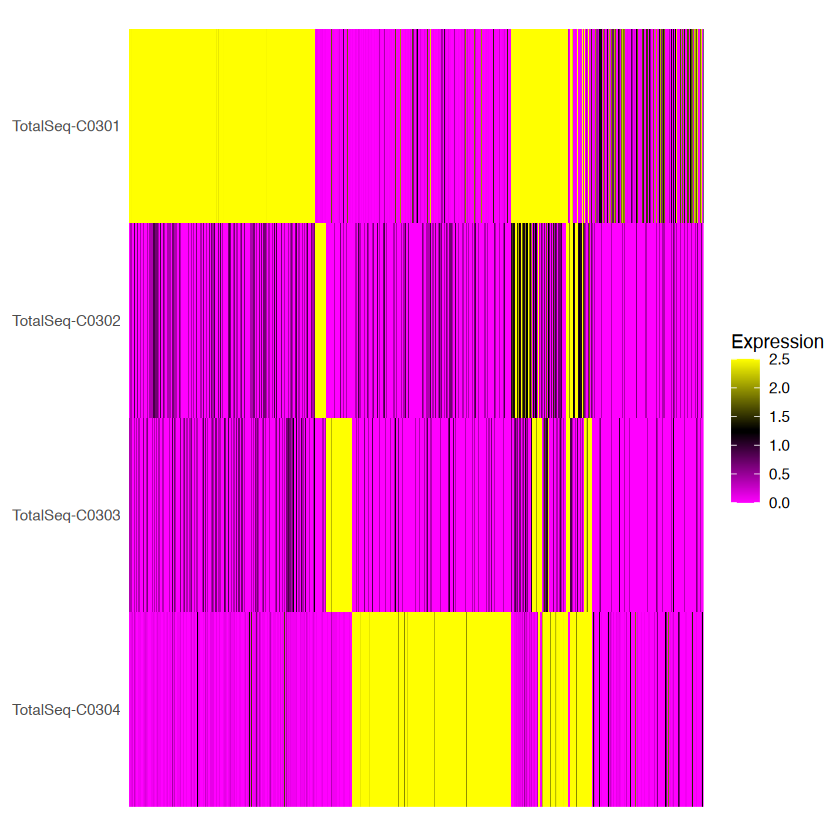

In [12]:
for (srat in srat_list) {
    print(HTOHeatmap(srat, assay = "HTO"))
    print(table(srat$HTO_classification.global))
    print(table(srat$hash.ID))
}

